In [1]:
import optuna
import pandas as pd
import numpy as np
# 시계열 data split
from sklearn.model_selection import TimeSeriesSplit
# timeseriessplit 시각화
from matplotlib.patches import Patch
import matplotlib.pyplot as plt
# 모델
from sklearn.metrics import mean_squared_error
from lightgbm import LGBMRegressor
cmap_data = plt.cm.Paired
cmap_cv = plt.cm.coolwarm
plt.style.use('fivethirtyeight')

In [2]:
# timeseriessplit 시각화용 함수
def plot_cv_indices(cv, X, n_splits, lw=10):
    
    fig, ax = plt.subplots()
    """Create a sample plot for indices of a cross-validation object."""

    # Generate the training/testing visualizations for each CV split
    for ii, (tr, tt) in enumerate(cv.split(X=X)):
        # Fill in indices with the training/test groups
        indices = np.array([np.nan] * len(X))
        indices[tt] = 1
        indices[tr] = 0

        # Visualize the results
        ax.scatter(range(len(indices)), [ii + .5] * len(indices),
                   c=indices, marker='_', lw=lw, cmap=cmap_cv,
                   vmin=-.2, vmax=1.2)

    # Formatting
    yticklabels = list(range(n_splits))
    ax.set(yticks=np.arange(n_splits) + .5, yticklabels=yticklabels,
           xlabel='Sample index', ylabel="CV iteration",
           ylim=[n_splits+0.1, -.1], xlim=[0, len(X)])
    ax.set_title('{}'.format(type(cv).__name__), fontsize=15)
    
    ax.legend([Patch(color=cmap_cv(.8)), Patch(color=cmap_cv(.02))],
          ['Testing set', 'Training set'], loc=(1.02, .8))

In [3]:
# blocked TimeSeriesSplit 용 class 정의
class BlockingTimeSeriesSplit():
    def __init__(self, n_splits):
        self.n_splits = n_splits
    
    def get_n_splits(self, groups):
        return self.n_splits
    
    def split(self, X, y=None, groups=None):
        n_samples = len(X)
        k_fold_size = n_samples // self.n_splits
        indices = np.arange(n_samples)
    
        margin = 0
        for i in range(self.n_splits):
            start = i * k_fold_size
            stop = start + k_fold_size
            mid = int(0.8 * (stop - start)) + start
            yield indices[start: mid], indices[mid + margin: stop]

# training 데이터 셋 만들기

## 1. gens : 실제 발전량 ( y로 쓸 예정 ) 
## 2. p_gens : 모델별 발전량 ( x변수로 추가 할 예정 )
## 3. wf : 기상 예측량 ( x변수로 추가 할 예정 )

In [4]:
gens = pd.read_csv("../data/OIBC2023_data/gens.csv")
p_gens = pd.read_csv("../data/OIBC2023_data/pred.csv")
wf = pd.read_csv("../data/OIBC2023_data/weather_forecast.csv")
add_gens = pd.read_csv('../data/OIBC2023_data/add_gens.csv')

In [5]:
gens = pd.concat([gens, add_gens], axis = 0)

In [6]:
gens

,time,amount
0,2022-06-19 01:00:00+09:00,0.0
1,2022-06-19 02:00:00+09:00,0.0
2,2022-06-19 03:00:00+09:00,0.0
3,2022-06-19 04:00:00+09:00,0.0
4,2022-06-19 05:00:00+09:00,0.0
...,...,...
643,2023-11-12 20:00:00+09:00,0.0
644,2023-11-12 21:00:00+09:00,0.0
645,2023-11-12 22:00:00+09:00,0.0
646,2023-11-12 23:00:00+09:00,0.0


In [31]:
p_gens

,round,time,model_id,amount
0,1,2022-06-19 01:00:00+09:00,0,0.0
1,1,2022-06-19 01:00:00+09:00,1,0.0
2,1,2022-06-19 01:00:00+09:00,2,0.0
3,1,2022-06-19 01:00:00+09:00,3,0.0
4,1,2022-06-19 01:00:00+09:00,4,0.0
...,...,...,...,...
116035,2,2023-10-16 00:00:00+09:00,0,0.0
116036,2,2023-10-16 00:00:00+09:00,1,0.0
116037,2,2023-10-16 00:00:00+09:00,2,0.0
116038,2,2023-10-16 00:00:00+09:00,3,0.0


## 날씨 예측을 10시에 한번 17시에 한번 진행 함으로 2개로 나눠야함.

In [78]:
# 날씨 예측량을 round1,2로 분리함
wf_round1 = wf[wf["round"]==1]
wf_round2 = wf[wf["round"]==2]

In [79]:
wf_round1.drop(["round"],axis=1,inplace=True)
wf_round2.drop(["round"],axis=1,inplace=True)

C:\Users\admin\AppData\Local\Temp\ipykernel_29096\3743235756.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  wf_round1.drop(["round"],axis=1,inplace=True)
C:\Users\admin\AppData\Local\Temp\ipykernel_29096\3743235756.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  wf_round2.drop(["round"],axis=1,inplace=True)


## p_gens를 x변수로 만들기 위해서 모델별로 분리

In [80]:
# 발전량 예측량을 모델별로 분리해서 변수로 만들라고 분리하는거
# round1에 대해 진행할 경우에 이거 실행
p_gens10 = p_gens.loc[(p_gens["model_id"]==0) & (p_gens["round"]==1)].reset_index()
p_gens11 = p_gens.loc[(p_gens["model_id"]==1) & (p_gens["round"]==1)].reset_index()
p_gens12 = p_gens.loc[(p_gens["model_id"]==2) & (p_gens["round"]==1)].reset_index()
p_gens13 = p_gens.loc[(p_gens["model_id"]==3) & (p_gens["round"]==1)].reset_index()
p_gens14 = p_gens.loc[(p_gens["model_id"]==4) & (p_gens["round"]==1)].reset_index()


In [81]:
# 발전량 예측량을 모델별로 분리해서 변수로 만들라고 분리하는거
# round2에 대해 진행할 경우에 이거 실행
p_gens20 = p_gens.loc[(p_gens["model_id"]==0) & (p_gens["round"]==2)].reset_index()
p_gens21 = p_gens.loc[(p_gens["model_id"]==1) & (p_gens["round"]==2)].reset_index()
p_gens22 = p_gens.loc[(p_gens["model_id"]==2) & (p_gens["round"]==2)].reset_index()
p_gens23 = p_gens.loc[(p_gens["model_id"]==3) & (p_gens["round"]==2)].reset_index()
p_gens24 = p_gens.loc[(p_gens["model_id"]==4) & (p_gens["round"]==2)].reset_index()

## p_gens 변수로 만들어진 데이터 셋, wf로 만든 데이터셋을 통합해야함. 시간을 기준으로 통합 예정

In [82]:
# p_gens(모델 예측량) 데이터 프레임 생성
x_df1 = pd.DataFrame({"m0": p_gens10["amount"],"m1": p_gens11["amount"],
              "m2": p_gens12["amount"],"m3": p_gens13["amount"],
              "time" : p_gens10["time"]})
x_df2 = pd.DataFrame({"m0": p_gens20["amount"],"m1": p_gens21["amount"],
              "m2": p_gens22["amount"],"m3": p_gens23["amount"],
              "time" : p_gens20["time"]})

In [83]:
# 10월 발전량 데이터 추가 round 1
for i in range(21,32):
    exec(f"a = pd.read_csv('../data/gen_fcst_10_2023-10-{i}.csv')")
    a.columns = ["time","m0","m1","m2","m3","m4"]
    a = a[["m0","m1","m2","m3","time"]]
    x_df1 = pd.concat([x_df1,a],axis=0)
    

# 10월 발전량 데이터 추가 round 2
for i in range(21,32):
    exec(f"a = pd.read_csv('../data/gen_fcst_17_2023-10-{i}.csv')")
    a.columns = ["time","m0","m1","m2","m3","m4"]
    a = a[["m0","m1","m2","m3","time"]]
    x_df2 = pd.concat([x_df2,a],axis=0)

In [84]:
# 11월 발전량 데이터 추가 round 1
for i in range(1,10):
    exec(f"a = pd.read_csv('../data/gen_fcst_10_2023-11-0{i}.csv')")
    a.columns = ["time","m0","m1","m2","m3","m4"]
    a = a[["m0","m1","m2","m3","time"]]
    x_df1 = pd.concat([x_df1,a],axis=0)
    
for i in range(10,13):
    exec(f"a = pd.read_csv('../data/gen_fcst_10_2023-11-{i}.csv')")
    a.columns = ["time","m0","m1","m2","m3","m4"]
    a = a[["m0","m1","m2","m3","time"]]
    x_df1 = pd.concat([x_df1,a],axis=0)

# 11월 발전량 데이터 추가 round 2
for i in range(1,10):
    exec(f"a = pd.read_csv('../data/gen_fcst_17_2023-11-0{i}.csv')")
    a.columns = ["time","m0","m1","m2","m3","m4"]
    a = a[["m0","m1","m2","m3","time"]]
    x_df2 = pd.concat([x_df2,a],axis=0)

for i in range(10,13):
    exec(f"a = pd.read_csv('../data/gen_fcst_17_2023-11-{i}.csv')")
    a.columns = ["time","m0","m1","m2","m3","m4"]
    a = a[["m0","m1","m2","m3","time"]]
    x_df2 = pd.concat([x_df2,a],axis=0)

In [85]:
# 10월 날씨 데이터 추가 round 1
for i in range(21,32):
    exec(f"a = pd.read_csv('../data/weather_forecasts/wf10_2023-10-{i}.csv')")
    wf_round1 = pd.concat([wf_round1,a],axis=0)
    

# 10월 날씨 데이터 추가 round 2
for i in range(21,32):
    exec(f"a = pd.read_csv('../data/weather_forecasts/wf17_2023-10-{i}.csv')")
    wf_round2 = pd.concat([wf_round2,a],axis=0)

In [88]:
# 11월 날씨 데이터 추가 round 1
for i in range(1,10):
    exec(f"a = pd.read_csv('../data/weather_forecasts/wf10_2023-11-0{i}.csv')")
    wf_round1 = pd.concat([wf_round1,a],axis=0)

for i in range(10,13):
    exec(f"a = pd.read_csv('../data/weather_forecasts/wf10_2023-11-{i}.csv')")
    wf_round1 = pd.concat([wf_round1,a],axis=0)

# 11월 날씨 데이터 추가 round 2
for i in range(1,10):
    exec(f"a = pd.read_csv('../data/weather_forecasts/wf17_2023-11-0{i}.csv')")
    wf_round2 = pd.concat([wf_round2,a],axis=0)
    
for i in range(10,13):
    exec(f"a = pd.read_csv('../data/weather_forecasts/wf17_2023-11-{i}.csv')")
    wf_round2 = pd.concat([wf_round2,a],axis=0)

In [39]:
# time을 기준으로 두 데이터 병합 ( p_gens, wf )
# 1차 모델링의 Y값으로 쓰일 발전량 gens도 같이 병합
# round2에 대해 수행해야하면 wf_round2/ 아니면 wf_round1
xy_df1 = pd.merge(x_df1,wf_round1,on="time")
xy_df1 = pd.merge(xy_df1,gens,on="time")

# 월과 날짜 변수를 추가 할 것임, 또한 시간대를 기준으로 데이터프레임을 3개 생성해야함으로 hour 변수도 추가
xy_df1["time"]=pd.to_datetime(xy_df1["time"])
xy_df1["month"]=xy_df1["time"].dt.month
xy_df1["day"]=xy_df1["time"].dt.day
xy_df1["hour"]=xy_df1["time"].dt.hour

# round2에 대해 수행해야하면 wf_round2/ 아니면 wf_round1
xy_df2 = pd.merge(x_df2,wf_round2,on="time")
xy_df2 = pd.merge(xy_df2,gens,on="time")

# 월2 날짜 변수를 추가 할 것임, 또한 시간대를 기준으로 데이터프레임을 3개 생성해야함으로 hour 변수도 추가
xy_df2["time"]=pd.to_datetime(xy_df2["time"])
xy_df2["month"]=xy_df2["time"].dt.month
xy_df2["day"]=xy_df2["time"].dt.day
xy_df2["hour"]=xy_df2["time"].dt.hour


In [40]:
# 시간에 따라 전체 통합된 데이터셋을 3개로 분리
# 7-10, 11-14 , 15-19
xy_df1_1 = xy_df1[(xy_df1["hour"]<=10) & (xy_df1["hour"]>=7)]
xy_df1_2 = xy_df1[(xy_df1["hour"]<=14) & (xy_df1["hour"]>=11)]
xy_df1_3 = xy_df1[(xy_df1["hour"]<=19) & (xy_df1["hour"]>=15)]

xy_df2_1 = xy_df2[(xy_df2["hour"]<=10) & (xy_df2["hour"]>=7)]
xy_df2_2 = xy_df2[(xy_df2["hour"]<=14) & (xy_df2["hour"]>=11)]
xy_df2_3 = xy_df2[(xy_df2["hour"]<=19) & (xy_df2["hour"]>=15)]

In [41]:
# 1차 모델링에서 사용할 X데이터셋 생성
# 데이터프레임 이름 읽는 법.
# 변수_몇차모델링_시간분리
# 시간 분리는 (1. 7-10 / 2. 11-14 / 3. 15-19)
# ex) x_df1_1 (x데이터셋, 1차 모델링, 7-10)
x_df11_1 = xy_df1_1[["m0","m1","m2","m3","uv_idx","elevation"]]
x_df11_2 = xy_df1_2[["m0","m1","m2","m3","uv_idx","elevation"]]
x_df11_3 = xy_df1_3[["m0","m1","m2","m3","uv_idx","elevation"]]
x_df12_1 = xy_df1_1.drop(["round","amount","m0","m1","m2","m3","uv_idx","elevation","time","hour"],axis=1)
x_df12_2 = xy_df1_2.drop(["round","amount","m0","m1","m2","m3","uv_idx","elevation","time","hour"],axis=1)
x_df12_3 = xy_df1_3.drop(["round","amount","m0","m1","m2","m3","uv_idx","elevation","time","hour"],axis=1)

x_df21_1 = xy_df2_1[["m0","m1","m2","m3","uv_idx","elevation"]]
x_df21_2 = xy_df2_2[["m0","m1","m2","m3","uv_idx","elevation"]]
x_df21_3 = xy_df2_3[["m0","m1","m2","m3","uv_idx","elevation"]]
x_df22_1 = xy_df2_1.drop(["round","amount","m0","m1","m2","m3","uv_idx","elevation","time","hour"],axis=1)
x_df22_2 = xy_df2_2.drop(["round","amount","m0","m1","m2","m3","uv_idx","elevation","time","hour"],axis=1)
x_df22_3 = xy_df2_3.drop(["round","amount","m0","m1","m2","m3","uv_idx","elevation","time","hour"],axis=1)

In [42]:
# 1차 모델링에서 사용할 Y데이터셋 생성
# 표기 법은 X와 동일
# 다만 2차 모델링에서 사용할 Y는 1차 모델링에서 구한 Y_hat을 실제 Y에서 뺀 e임으로 추후에 구해야함
# e = Y - Y_hat
y_df11_1 = xy_df1_1["amount"]
y_df11_2 = xy_df1_2["amount"]
y_df11_3 = xy_df1_3["amount"]

# e = Y - Y_hat
y_df21_1 = xy_df2_1["amount"]
y_df21_2 = xy_df2_2["amount"]
y_df21_3 = xy_df2_3["amount"]

### 데이터 저장

In [ ]:
# round 1 해당하는 데이터
x_df11_1.to_csv('../data/MLP2LGBM_V2/X_r1_M1_T1.csv', index = False)
x_df11_2.to_csv('../data/MLP2LGBM_V2/X_r1_M1_T2.csv', index = False)
x_df11_3.to_csv('../data/MLP2LGBM_V2/X_r1_M1_T3.csv', index = False)
x_df12_1.to_csv('../data/MLP2LGBM_V2/X_r1_M2_T1.csv', index = False)
x_df12_2.to_csv('../data/MLP2LGBM_V2/X_r1_M2_T2.csv', index = False)
x_df12_3.to_csv('../data/MLP2LGBM_V2/X_r1_M2_T3.csv', index = False)
y_df11_1.to_csv('../data/MLP2LGBM_V2/Y_r1_M1_T1.csv', index = False)
y_df11_2.to_csv('../data/MLP2LGBM_V2/Y_r1_M1_T2.csv', index = False)
y_df11_3.to_csv('../data/MLP2LGBM_V2/Y_r1_M1_T3.csv', index = False)

# round 2 해당하는 데이터
x_df21_1.to_csv('../data/MLP2LGBM_V2/X_r2_M1_T1.csv', index = False)
x_df21_2.to_csv('../data/MLP2LGBM_V2/X_r2_M1_T2.csv', index = False)
x_df21_3.to_csv('../data/MLP2LGBM_V2/X_r2_M1_T3.csv', index = False)
x_df22_1.to_csv('../data/MLP2LGBM_V2/X_r2_M2_T1.csv', index = False)
x_df22_2.to_csv('../data/MLP2LGBM_V2/X_r2_M2_T2.csv', index = False)
x_df22_3.to_csv('../data/MLP2LGBM_V2/X_r2_M2_T3.csv', index = False)
y_df21_1.to_csv('../data/MLP2LGBM_V2/Y_r2_M1_T1.csv', index = False)
y_df21_2.to_csv('../data/MLP2LGBM_V2/Y_r2_M1_T2.csv', index = False)
y_df21_3.to_csv('../data/MLP2LGBM_V2/Y_r2_M1_T3.csv', index = False)

# 모델링1 선형관계 linear or mlp (모델은 바뀔수 있음)

## torch 패키지 import 및 CPU/GPU 할당

In [150]:
import pickle
import numpy as np
import pandas as pd

# model
import torch
import torch.nn as nn
import torch.nn.functional as F

from torchsummary import summary
from torch import optim
from torch.optim.lr_scheduler import StepLR
from torch.optim.lr_scheduler import ReduceLROnPlateau 

from torch.utils.data import Dataset, DataLoader


# display images
import matplotlib.pyplot as plt
%matplotlib inline

# utils
import os
from torchsummary import summary
import time
import copy

from torch_utils_MLP import timeseriesKFoldCV, train_val, seed_everything

In [138]:
if torch.cuda.is_available():
    DEVICE = torch.device('cuda')
else:
    DEVICE = torch.device('cpu')
print(DEVICE)

cuda


## 데이터 불러오기 및 스케일링 진행

In [139]:
X_r1_M1_T1 = pd.read_csv('../data/MLP2LGBM_V2/X_r1_M1_T1.csv')
X_r1_M1_T2 = pd.read_csv('../data/MLP2LGBM_V2/X_r1_M1_T2.csv')
X_r1_M1_T3 = pd.read_csv('../data/MLP2LGBM_V2/X_r1_M1_T3.csv')
Y_r1_M1_T1 = pd.read_csv('../data/MLP2LGBM_V2/Y_r1_M1_T1.csv')
Y_r1_M1_T2 = pd.read_csv('../data/MLP2LGBM_V2/Y_r1_M1_T2.csv')
Y_r1_M1_T3 = pd.read_csv('../data/MLP2LGBM_V2/Y_r1_M1_T3.csv')

X_r2_M1_T1 = pd.read_csv('../data/MLP2LGBM_V2/X_r2_M1_T1.csv')
X_r2_M1_T2 = pd.read_csv('../data/MLP2LGBM_V2/X_r2_M1_T2.csv')
X_r2_M1_T3 = pd.read_csv('../data/MLP2LGBM_V2/X_r2_M1_T3.csv')
Y_r2_M1_T1 = pd.read_csv('../data/MLP2LGBM_V2/Y_r2_M1_T1.csv')
Y_r2_M1_T2 = pd.read_csv('../data/MLP2LGBM_V2/Y_r2_M1_T2.csv')
Y_r2_M1_T3 = pd.read_csv('../data/MLP2LGBM_V2/Y_r2_M1_T3.csv')

In [140]:
from sklearn.preprocessing import MinMaxScaler, RobustScaler

# round: 1 / Modeling: 1 / TimeFold : 1, 2, 3
mms_X_111 = MinMaxScaler()
mms_X_112 = MinMaxScaler()
mms_X_113 = MinMaxScaler()
mms_X_111.fit(X_r1_M1_T1)
mms_X_112.fit(X_r1_M1_T2)
mms_X_113.fit(X_r1_M1_T3)
X_r1_M1_T1_scaled = mms_X_111.transform(X_r1_M1_T1)
X_r1_M1_T2_scaled = mms_X_112.transform(X_r1_M1_T2)
X_r1_M1_T3_scaled = mms_X_113.transform(X_r1_M1_T3)


Y_r1_M1_T1 = np.array(Y_r1_M1_T1).reshape(-1, 1)
Y_r1_M1_T2 = np.array(Y_r1_M1_T2).reshape(-1, 1)
Y_r1_M1_T3 = np.array(Y_r1_M1_T3).reshape(-1, 1)
mms_Y_111 = MinMaxScaler()
mms_Y_112 = MinMaxScaler()
mms_Y_113 = MinMaxScaler()
mms_Y_111.fit(Y_r1_M1_T1)
mms_Y_112.fit(Y_r1_M1_T2)
mms_Y_113.fit(Y_r1_M1_T3)
Y_r1_M1_T1_scaled = mms_Y_111.transform(Y_r1_M1_T1)
Y_r1_M1_T2_scaled = mms_Y_112.transform(Y_r1_M1_T2)
Y_r1_M1_T3_scaled = mms_Y_113.transform(Y_r1_M1_T3)

# train_Y = np.array(train_Y).reshape(-1, 1) # 원래 Y는 (-1,)차원, sklearn의 scaler들은 2차원 이상의 인풋을 기대함
# test_Y = np.array(test_Y).reshape(-1, 1) # 차원을 맞춰줘야 에러가 발생하지 않음

In [141]:
from sklearn.preprocessing import MinMaxScaler, RobustScaler

# round: 1 / Modeling: 1 / TimeFold : 1, 2, 3
mms_X_211 = MinMaxScaler()
mms_X_212 = MinMaxScaler()
mms_X_213 = MinMaxScaler()
mms_X_211.fit(X_r2_M1_T1)
mms_X_212.fit(X_r2_M1_T2)
mms_X_213.fit(X_r2_M1_T3)
X_r2_M1_T1_scaled = mms_X_111.transform(X_r2_M1_T1)
X_r2_M1_T2_scaled = mms_X_112.transform(X_r2_M1_T2)
X_r2_M1_T3_scaled = mms_X_113.transform(X_r2_M1_T3)


Y_r2_M1_T1 = np.array(Y_r2_M1_T1).reshape(-1, 1)
Y_r2_M1_T2 = np.array(Y_r2_M1_T2).reshape(-1, 1)
Y_r2_M1_T3 = np.array(Y_r2_M1_T3).reshape(-1, 1)
mms_Y_211 = MinMaxScaler()
mms_Y_212 = MinMaxScaler()
mms_Y_213 = MinMaxScaler()
mms_Y_211.fit(Y_r2_M1_T1)
mms_Y_212.fit(Y_r2_M1_T2)
mms_Y_213.fit(Y_r2_M1_T3)
Y_r2_M1_T1_scaled = mms_Y_211.transform(Y_r2_M1_T1)
Y_r2_M1_T2_scaled = mms_Y_212.transform(Y_r2_M1_T2)
Y_r2_M1_T3_scaled = mms_Y_213.transform(Y_r2_M1_T3)

# train_Y = np.array(train_Y).reshape(-1, 1) # 원래 Y는 (-1,)차원, sklearn의 scaler들은 2차원 이상의 인풋을 기대함
# test_Y = np.array(test_Y).reshape(-1, 1) # 차원을 맞춰줘야 에러가 발생하지 않음

## 데이터 객체 선언 및 할당

In [142]:
class mlpDataset(Dataset):
    def __init__(self, X, Y):
        self.X = torch.tensor(X, dtype = torch.float32)#.type(torch.DoubleTensor)#.type(torch.float32)
        self.Y = torch.tensor(Y, dtype = torch.float32)#.type(torch.DoubleTensor)#.type(torch.float32)

    def __len__(self):
        return len(self.X)

    def __getitem__(self, idx):
        return self.X[idx], self.Y[idx]

In [143]:
from sklearn.model_selection import TimeSeriesSplit

# 시계열 k-Fold를 위한 인덱스 할당
n_split = 5
tscv = TimeSeriesSplit(n_splits=n_split)

tscv_train_idx = []
tscv_valid_idx = []
for idx in tscv.split(X_r1_M1_T1_scaled):
    tscv_train_idx.append(idx[0])
    tscv_valid_idx.append(idx[1])

In [144]:
for t, v in zip(tscv_train_idx, tscv_valid_idx):
    print(len(t), len(v))

326 322
648 322
970 322
1292 322
1614 322


In [145]:
seed = 42
seed_everything(seed)
num_batch = 128

train_ds111 = mlpDataset(X_r1_M1_T1_scaled, Y_r1_M1_T1_scaled)
train_dl111 = DataLoader(train_ds111, batch_size = num_batch, shuffle = True)

train_ds112 = mlpDataset(X_r1_M1_T2_scaled, Y_r1_M1_T2_scaled)
train_dl112 = DataLoader(train_ds112, batch_size = num_batch, shuffle = True)

train_ds113 = mlpDataset(X_r1_M1_T3_scaled, Y_r1_M1_T3_scaled)
train_dl113 = DataLoader(train_ds113, batch_size = num_batch, shuffle = True)

In [146]:
seed = 42
seed_everything(seed)
num_batch = 128

train_ds211 = mlpDataset(X_r2_M1_T1_scaled, Y_r2_M1_T1_scaled)
train_dl211 = DataLoader(train_ds211, batch_size = num_batch, shuffle = True)
train_ds212 = mlpDataset(X_r2_M1_T2_scaled, Y_r2_M1_T2_scaled)
train_dl212 = DataLoader(train_ds212, batch_size = num_batch, shuffle = True)
train_ds213 = mlpDataset(X_r2_M1_T3_scaled, Y_r2_M1_T3_scaled)
train_dl213 = DataLoader(train_ds213, batch_size = num_batch, shuffle = True)

## 모델 선언

In [147]:
# 모델 구조 정의
class MLP_regressor(nn.Module):
    def __init__(self, num_features):
        super().__init__()
        self.fc1 = nn.Linear(num_features, 32).type(torch.float32)#.type(torch.float32)
        self.fc2 = nn.Linear(32, 64).type(torch.float32)#.type(torch.float32) 
        self.fc3 = nn.Linear(64, 128).type(torch.float32)#.type(torch.float32) 
        self.fc4 = nn.Linear(128, 64).type(torch.float32)#.type(torch.float32)
        self.fc5 = nn.Linear(64, 32).type(torch.float32)#.type(torch.float32)
        self.fc6 = nn.Linear(32, 16).type(torch.float32)#.type(torch.float32)
        self.fc7 = nn.Linear(16, 8).type(torch.float32)#.type(torch.float32)
        self.fc8 = nn.Linear(8, 1).type(torch.float32)#.type(torch.float32)
        
        # type()

        self.dropout = nn.Dropout(0.4)
        # self.softplus = nn.Softplus()

    def forward(self, x): 
        x = torch.sigmoid(self.fc1(x))
        x = self.dropout(torch.sigmoid(self.fc2(x)))
        x = self.dropout(torch.sigmoid(self.fc3(x)))
        x = self.dropout(torch.sigmoid(self.fc4(x)))
        x = torch.sigmoid(self.fc5(x))
        x = torch.sigmoid(self.fc6(x))
        x = torch.sigmoid(self.fc7(x))
        x = torch.sigmoid(self.fc8(x))
      
        return x

## k-fold 평가 진행

In [154]:
loss_func = nn.MSELoss(reduction = 'sum').to(DEVICE)

def hyperParamTuning(classModel, objDataset, objDataLoader, X, Y, expName):
    # definc the training parameters
    model_params = {
        'num_epochs': 5000,
        'loss_func': loss_func,

        'X': X,
        'Y': Y,
        'tscv_train_idx': tscv_train_idx,
        'tscv_valid_idx': tscv_valid_idx,
        'batch_size': 128,

        'sanity_check': False, # True인 경우 데이터 조금만(batch 1개) 사용해서 학습 코드가 잘 돌아가는지 확인 / False면 데이터 전체 사용
        # 'lr_scheduler': lr_scheduler,
        'path2weights': f'../model/testMLP/{expName}.pt', # 모델 파라미터를 저장할 경로
        'DEVICE': DEVICE, # cpu / cuda
        'early_stopping': True, # 학습 조기 종료 적용 여부 -> True: 적용 / False: 미적용
        'patience_limit': 500
        # 'num_folds': n_split
    }
    
    seed = 42
    seed_everything(seed)
    
    model = classModel(num_features = 6)
    
    best_loss = float('inf')
    
    for LR in [0.01, 0.001, 0.0001]:
            model_params['learning_rate'] = LR
            
            avg_loss, model_params = timeseriesKFoldCV(MLP_regressor, objDataset, objDataLoader, model_params)
            if avg_loss < best_loss:
                best_loss = avg_loss
                model_params['avg_loss'] = avg_loss
                with open(model_params['path2weights'][:-2]+'pickle','wb') as fw:
                    pickle.dump(model_params, fw)
            else:
                continue
    return 0
            

In [153]:
hyperParamTuning(classModel = MLP_regressor,
                 objDataset = mlpDataset, objDataLoader = DataLoader,
                 X = X_r1_M1_T1_scaled, Y = Y_r1_M1_T1_scaled,
                 expName = 'MLP_r1_M1_T1')
hyperParamTuning(classModel = MLP_regressor,
                 objDataset = mlpDataset, objDataLoader = DataLoader,
                 X = X_r1_M1_T2_scaled, Y = Y_r1_M1_T2_scaled,
                 expName = 'MLP_r1_M1_T2')
hyperParamTuning(classModel = MLP_regressor,
                 objDataset = mlpDataset, objDataLoader = DataLoader,
                 X = X_r1_M1_T3_scaled, Y = Y_r1_M1_T3_scaled,
                 expName = 'MLP_r1_M1_T3')

Train on fold-0
Copied best model weights!
Get best val_loss
Epoch 0/4999, current lr=0.01
train loss: 0.021026, val loss: 0.089696, mse: 0.09, time: 0.0004 min
----------
Copied best model weights!
Get best val_loss
Copied best model weights!
Get best val_loss
Copied best model weights!
Get best val_loss
Copied best model weights!
Get best val_loss
Copied best model weights!
Get best val_loss
Copied best model weights!
Get best val_loss
Copied best model weights!
Get best val_loss
Copied best model weights!
Get best val_loss
Copied best model weights!
Get best val_loss
Copied best model weights!
Get best val_loss
Copied best model weights!
Get best val_loss
Copied best model weights!
Get best val_loss
Copied best model weights!
Get best val_loss
Copied best model weights!
Get best val_loss
Copied best model weights!
Get best val_loss
Copied best model weights!
Get best val_loss
Copied best model weights!
Get best val_loss
Copied best model weights!
Get best val_loss
Copied best model 

TypeError: '<' not supported between instances of 'tuple' and 'float'

## k-fold 결과 확인

In [17]:
with open('../model/testMLP/MLP_r1_M1_T1.pickle', 'rb') as fr:
    MLP_r1_M1_T1_params = pickle.load(fr)
print(MLP_r1_M1_T1_params['optimizer'])
print(MLP_r1_M1_T1_params['learning_rate'])

SGD (
Parameter Group 0
    dampening: 0
    foreach: None
    lr: 3.90625e-05
    maximize: False
    momentum: 0.0
    nesterov: False
    weight_decay: 0
)
0.01


In [18]:
with open('../model/testMLP/MLP_r1_M1_T2.pickle', 'rb') as fr:
    MLP_r1_M1_T2_params = pickle.load(fr)
print(MLP_r1_M1_T2_params['optimizer'])
print(MLP_r1_M1_T2_params['learning_rate'])

SGD (
Parameter Group 0
    dampening: 0
    foreach: None
    lr: 7.8125e-05
    maximize: False
    momentum: 0.0
    nesterov: False
    weight_decay: 0
)
0.01


In [19]:
with open('../model/testMLP/MLP_r1_M1_T3.pickle', 'rb') as fr:
    MLP_r1_M1_T3_params = pickle.load(fr)
print(MLP_r1_M1_T3_params['optimizer'])
print(MLP_r1_M1_T3_params['learning_rate'])

SGD (
Parameter Group 0
    dampening: 0
    foreach: None
    lr: 3.90625e-05
    maximize: False
    momentum: 0.0
    nesterov: False
    weight_decay: 0
)
0.01


## 학습 설정

### round1

In [22]:
seed = 42
seed_everything(seed)
m1_mlp11 = MLP_regressor(num_features = X_r1_M1_T1.shape[1]).to(DEVICE) # num_features = 6
m1_mlp12 = MLP_regressor(num_features = X_r1_M1_T1.shape[1]).to(DEVICE) # num_features = 6
m1_mlp13 = MLP_regressor(num_features = X_r1_M1_T1.shape[1]).to(DEVICE) # num_features = 6

loss_func = nn.MSELoss(reduction = 'sum').to(DEVICE) # utils 내에서 데이터 개수로 나누기 때문에 -> 기본값 평균이 아닌 sum으로 적용

In [121]:
opt = optim.SGD(m1_mlp11.parameters(), lr = 0.01, momentum = 0.0) # Adam에 모델의 학습 파라미터를 넣어줌
lr_scheduler = ReduceLROnPlateau(opt, mode='min', factor = 0.5, patience = 250)

m1_mlp11_params = {
    'num_epochs': 5000,
    'loss_func': loss_func,
    'optimizer': opt,

    'train_dl': train_dl111,
    'val_dl': None,
    'batch_size': 32,

    'sanity_check': False, # True인 경우 데이터 조금만(batch 1개) 사용해서 학습 코드가 잘 돌아가는지 확인 / False면 데이터 전체 사용
    'lr_scheduler': lr_scheduler,
    'path2weights': '../model/MLP2LGBM_V2/round1/m1_mlp1.pt', # 모델 파라미터를 저장할 경로
    'DEVICE': DEVICE, # cpu / cuda
    'early_stopping': True, # 학습 조기 종료 적용 여부 -> True: 적용 / False: 미적용
    'patience_limit': 500,
    'num_folds': n_split
}

In [24]:
opt = optim.SGD(m1_mlp12.parameters(), lr = 0.01, momentum = 0.0) # Adam에 모델의 학습 파라미터를 넣어줌
lr_scheduler = ReduceLROnPlateau(opt, mode='min', factor = 0.5, patience = 250)

m1_mlp12_params = {
    'num_epochs': 5000,
    'loss_func': loss_func,
    'optimizer': opt,

    'train_dl': train_dl112,
    'val_dl': None,
    'batch_size': 32,

    'sanity_check': False, # True인 경우 데이터 조금만(batch 1개) 사용해서 학습 코드가 잘 돌아가는지 확인 / False면 데이터 전체 사용
    'lr_scheduler': lr_scheduler,
    'path2weights': '../model/MLP2LGBM_V2/round1/m1_mlp12.pt', # 모델 파라미터를 저장할 경로
    'DEVICE': DEVICE, # cpu / cuda
    'early_stopping': True, # 학습 조기 종료 적용 여부 -> True: 적용 / False: 미적용
    'patience_limit': 500,
    'num_folds': n_split
}

In [25]:
opt = optim.SGD(m1_mlp13.parameters(), lr = 0.01, momentum = 0.0) # Adam에 모델의 학습 파라미터를 넣어줌
lr_scheduler = ReduceLROnPlateau(opt, mode='min', factor = 0.5, patience = 250)

m1_mlp13_params = {
    'num_epochs': 5000,
    'loss_func': loss_func,
    'optimizer': opt,

    'train_dl': train_dl113,
    'val_dl': None,
    'batch_size': 32,

    'sanity_check': False, # True인 경우 데이터 조금만(batch 1개) 사용해서 학습 코드가 잘 돌아가는지 확인 / False면 데이터 전체 사용
    'lr_scheduler': lr_scheduler,
    'path2weights': '../model/MLP2LGBM_V2/round1/m1_mlp13.pt', # 모델 파라미터를 저장할 경로
    'DEVICE': DEVICE, # cpu / cuda
    'early_stopping': True, # 학습 조기 종료 적용 여부 -> True: 적용 / False: 미적용
    'patience_limit': 500,
    'num_folds': n_split
}

In [26]:
train_val(model = m1_mlp11, params = m1_mlp11_params)
train_val(model = m1_mlp12, params = m1_mlp12_params)
train_val(model = m1_mlp13, params = m1_mlp13_params)

Epoch 0/4999, current lr=0.01
train loss: 0.046792, val loss: 0.000000, mse: 0.00, time: 0.0020 min
----------
Epoch 100/4999, current lr=0.01
train loss: 0.046902, val loss: 0.000000, mse: 0.00, time: 0.2137 min
----------
Epoch 200/4999, current lr=0.01
train loss: 0.046812, val loss: 0.000000, mse: 0.00, time: 0.4208 min
----------
Epoch 300/4999, current lr=0.01
train loss: 0.046803, val loss: 0.000000, mse: 0.00, time: 0.6230 min
----------
Epoch 400/4999, current lr=0.01
train loss: 0.046797, val loss: 0.000000, mse: 0.00, time: 0.8434 min
----------
Epoch 500/4999, current lr=0.01
train loss: 0.046856, val loss: 0.000000, mse: 0.00, time: 1.0540 min
----------
Epoch 600/4999, current lr=0.01
train loss: 0.046710, val loss: 0.000000, mse: 0.00, time: 1.2556 min
----------
Epoch 700/4999, current lr=0.01
train loss: 0.046731, val loss: 0.000000, mse: 0.00, time: 1.4770 min
----------
Epoch 800/4999, current lr=0.01
train loss: 0.046779, val loss: 0.000000, mse: 0.00, time: 1.6713 

(MLP_regressor(
   (fc1): Linear(in_features=6, out_features=32, bias=True)
   (fc2): Linear(in_features=32, out_features=64, bias=True)
   (fc3): Linear(in_features=64, out_features=128, bias=True)
   (fc4): Linear(in_features=128, out_features=64, bias=True)
   (fc5): Linear(in_features=64, out_features=32, bias=True)
   (fc6): Linear(in_features=32, out_features=16, bias=True)
   (fc7): Linear(in_features=16, out_features=8, bias=True)
   (fc8): Linear(in_features=8, out_features=1, bias=True)
   (dropout): Dropout(p=0.4, inplace=False)
 ),
 {'train': [0.0436403494482198,
   0.04263676601993151,
   0.04267143222911299,
   0.04263084789445577,
   0.04257795086576919,
   0.04256741640981564,
   0.04265158604984441,
   0.042678090264974544,
   0.04264369638990765,
   0.042558369533089564,
   0.04259567659748487,
   0.04258428100219443,
   0.04261304260778033,
   0.04261780442777744,
   0.042571498958532475,
   0.042567377297346255,
   0.04259922233494845,
   0.04250781723290436,
   0.0

In [28]:
torch.save(m1_mlp11.state_dict(), '../model/MLP2LGBM_V2/round1/m1_mlp11.pt')
torch.save(m1_mlp12.state_dict(), '../model/MLP2LGBM_V2/round1/m1_mlp12.pt')
torch.save(m1_mlp13.state_dict(), '../model/MLP2LGBM_V2/round1/m1_mlp13.pt')

In [ ]:
# from sklearn.externals 
import joblib
scaler_filename1 = "../model/MLP2LGBM_V2/round1/mms_Y_r1_M1_T1.pkl"
scaler_filename2 = "../model/MLP2LGBM_V2/round1/mms_Y_r1_M1_T2.pkl"
scaler_filename3 = "../model/MLP2LGBM_V2/round1/mms_Y_r1_M1_T3.pkl"
joblib.dump(mms_Y_111, scaler_filename1) 
joblib.dump(mms_Y_112, scaler_filename2) 
joblib.dump(mms_Y_113, scaler_filename3) 

# And now to load...

# scaler = joblib.load(scaler_filename)

### round2

In [122]:
seed = 42
seed_everything(seed)
m1_mlp21 = MLP_regressor(num_features = X_r2_M1_T1.shape[1]).to(DEVICE) # num_features = 6
m1_mlp22 = MLP_regressor(num_features = X_r2_M1_T1.shape[1]).to(DEVICE) # num_features = 6
m1_mlp23 = MLP_regressor(num_features = X_r2_M1_T1.shape[1]).to(DEVICE) # num_features = 6

loss_func = nn.MSELoss(reduction = 'sum').to(DEVICE) # utils 내에서 데이터 개수로 나누기 때문에 -> 기본값 평균이 아닌 sum으로 적용

In [125]:
opt = optim.SGD(m1_mlp21.parameters(), lr = 0.01, momentum = 0.0) # Adam에 모델의 학습 파라미터를 넣어줌
lr_scheduler = ReduceLROnPlateau(opt, mode='min', factor = 0.5, patience = 250)

m1_mlp21_params = {
    'num_epochs': 5000,
    'loss_func': loss_func,
    'optimizer': opt,

    'train_dl': train_dl211,
    'val_dl': None,
    'batch_size': 32,

    'sanity_check': False, # True인 경우 데이터 조금만(batch 1개) 사용해서 학습 코드가 잘 돌아가는지 확인 / False면 데이터 전체 사용
    'lr_scheduler': lr_scheduler,
    'path2weights': '../model/MLP2LGBM_V2/round2/m1_mlp21.pt', # 모델 파라미터를 저장할 경로
    'DEVICE': DEVICE, # cpu / cuda
    'early_stopping': False, # 학습 조기 종료 적용 여부 -> True: 적용 / False: 미적용
    'patience_limit': 500,
    'num_folds': n_split
}

In [126]:
opt = optim.SGD(m1_mlp22.parameters(), lr = 0.01, momentum = 0.0) # Adam에 모델의 학습 파라미터를 넣어줌
lr_scheduler = ReduceLROnPlateau(opt, mode='min', factor = 0.5, patience = 250)

m1_mlp22_params = {
    'num_epochs': 5000,
    'loss_func': loss_func,
    'optimizer': opt,

    'train_dl': train_dl212,
    'val_dl': None,
    'batch_size': 32,

    'sanity_check': False, # True인 경우 데이터 조금만(batch 1개) 사용해서 학습 코드가 잘 돌아가는지 확인 / False면 데이터 전체 사용
    'lr_scheduler': lr_scheduler,
    'path2weights': '../model/MLP2LGBM_V2/round2/m1_mlp22.pt', # 모델 파라미터를 저장할 경로
    'DEVICE': DEVICE, # cpu / cuda
    'early_stopping': False, # 학습 조기 종료 적용 여부 -> True: 적용 / False: 미적용
    'patience_limit': 500,
    'num_folds': n_split
}

In [127]:
opt = optim.SGD(m1_mlp23.parameters(), lr = 0.01, momentum = 0.0) # Adam에 모델의 학습 파라미터를 넣어줌
lr_scheduler = ReduceLROnPlateau(opt, mode='min', factor = 0.5, patience = 250)

m1_mlp23_params = {
    'num_epochs': 5000,
    'loss_func': loss_func,
    'optimizer': opt,

    'train_dl': train_dl213,
    'val_dl': None,
    'batch_size': 32,

    'sanity_check': False, # True인 경우 데이터 조금만(batch 1개) 사용해서 학습 코드가 잘 돌아가는지 확인 / False면 데이터 전체 사용
    'lr_scheduler': lr_scheduler,
    'path2weights': '../model/MLP2LGBM_V2/round2/m1_mlp23.pt', # 모델 파라미터를 저장할 경로
    'DEVICE': DEVICE, # cpu / cuda
    'early_stopping': False, # 학습 조기 종료 적용 여부 -> True: 적용 / False: 미적용
    'patience_limit': 500,
    'num_folds': n_split
}

In [128]:
train_val(model = m1_mlp21, params = m1_mlp21_params)
train_val(model = m1_mlp22, params = m1_mlp22_params)
train_val(model = m1_mlp23, params = m1_mlp23_params)

Epoch 0/4999, current lr=0.01
train loss: 0.023765, val loss: 0.000000, mse: 0.00, time: 0.0050 min
----------
Epoch 100/4999, current lr=0.01
train loss: 0.023731, val loss: 0.000000, mse: 0.00, time: 0.0729 min
----------
Epoch 200/4999, current lr=0.01
train loss: 0.023768, val loss: 0.000000, mse: 0.00, time: 0.1404 min
----------
Epoch 300/4999, current lr=0.01
train loss: 0.023636, val loss: 0.000000, mse: 0.00, time: 0.2079 min
----------
Epoch 400/4999, current lr=0.01
train loss: 0.023622, val loss: 0.000000, mse: 0.00, time: 0.2762 min
----------
Epoch 500/4999, current lr=0.01
train loss: 0.023733, val loss: 0.000000, mse: 0.00, time: 0.3387 min
----------
Epoch 600/4999, current lr=0.01
train loss: 0.023745, val loss: 0.000000, mse: 0.00, time: 0.3992 min
----------
Epoch 700/4999, current lr=0.01
train loss: 0.023734, val loss: 0.000000, mse: 0.00, time: 0.4649 min
----------
Epoch 800/4999, current lr=0.01
train loss: 0.023631, val loss: 0.000000, mse: 0.00, time: 0.5334 

(MLP_regressor(
   (fc1): Linear(in_features=6, out_features=32, bias=True)
   (fc2): Linear(in_features=32, out_features=64, bias=True)
   (fc3): Linear(in_features=64, out_features=128, bias=True)
   (fc4): Linear(in_features=128, out_features=64, bias=True)
   (fc5): Linear(in_features=64, out_features=32, bias=True)
   (fc6): Linear(in_features=32, out_features=16, bias=True)
   (fc7): Linear(in_features=16, out_features=8, bias=True)
   (fc8): Linear(in_features=8, out_features=1, bias=True)
   (dropout): Dropout(p=0.4, inplace=False)
 ),
 {'train': [0.02235936465599725,
   0.0215628539872862,
   0.021481196712161494,
   0.021465978780722716,
   0.02147086646052317,
   0.021460339736147045,
   0.021459246671051407,
   0.02145256867547253,
   0.021455561075962432,
   0.021459195920540585,
   0.021480510640441135,
   0.02146362229501558,
   0.021457414805147162,
   0.021473379946348577,
   0.021454621152759094,
   0.02145419318646316,
   0.021465806248771698,
   0.0214652403756296,


In [129]:
torch.save(m1_mlp21.state_dict(), '../model/MLP2LGBM_V2/round2/m1_mlp21.pt')
torch.save(m1_mlp22.state_dict(), '../model/MLP2LGBM_V2/round2/m1_mlp22.pt')
torch.save(m1_mlp23.state_dict(), '../model/MLP2LGBM_V2/round2/m1_mlp23.pt')

In [130]:
# from sklearn.externals 
import joblib
scaler_filename1 = "../model/MLP2LGBM_V2/round2/mms_Y_r2_M1_T1.pkl"
scaler_filename2 = "../model/MLP2LGBM_V2/round2/mms_Y_r2_M1_T2.pkl"
scaler_filename3 = "../model/MLP2LGBM_V2/round2/mms_Y_r2_M1_T3.pkl"
joblib.dump(mms_Y_211, scaler_filename1) 
joblib.dump(mms_Y_212, scaler_filename2) 
joblib.dump(mms_Y_213, scaler_filename3) 

# And now to load...

# scaler = joblib.load(scaler_filename)

['../model/MLP/round2/mms_Y_r2_M1_T3.pkl']

## 2차 모델링에 사용할 y값을 만들어야함.
## 2차 모델링에서 사용할 y는 Y-Y_hat = e 임.

In [51]:
m1_mlp11 = MLP_regressor(6)
m1_mlp12 = MLP_regressor(6)
m1_mlp13 = MLP_regressor(6)
m1_mlp11.load_state_dict(torch.load('../model/MLP2LGBM_V2/round1/m1_mlp11.pt', map_location=torch.device('cpu')))
m1_mlp12.load_state_dict(torch.load('../model/MLP2LGBM_V2/round1/m1_mlp12.pt', map_location=torch.device('cpu')))
m1_mlp13.load_state_dict(torch.load('../model/MLP2LGBM_V2/round1/m1_mlp13.pt', map_location=torch.device('cpu')))

<All keys matched successfully>

In [131]:
m1_mlp21 = MLP_regressor(6)
m1_mlp22 = MLP_regressor(6)
m1_mlp23 = MLP_regressor(6)
m1_mlp21.load_state_dict(torch.load('../model/MLP2LGBM_V2/round2/m1_mlp21.pt', map_location=torch.device('cpu')))
m1_mlp22.load_state_dict(torch.load('../model/MLP2LGBM_V2/round2/m1_mlp22.pt', map_location=torch.device('cpu')))
m1_mlp23.load_state_dict(torch.load('../model/MLP2LGBM_V2/round2/m1_mlp23.pt', map_location=torch.device('cpu')))

<All keys matched successfully>

In [63]:
def mlpPredict(model, df):
    model.to(DEVICE)
    X = df.to_numpy()
    X = torch.tensor(X, dtype = torch.float32, device = DEVICE)
    
    model.eval()
    with torch.no_grad():
        # if DEVICE == 'cpu':
        pred = model(X).to('cpu').detach()
    
    model.train()
    return pred.numpy()

In [64]:
# 2차 모델링에 사용할 Y 데이터 셋 생성
pred_m1_mlp11 = mlpPredict(m1_mlp11, x_df11_1)
pred_m1_mlp12 = mlpPredict(m1_mlp12, x_df11_2)
pred_m1_mlp13 = mlpPredict(m1_mlp13, x_df11_3)

pred_m1_mlp11 = mms_Y_111.inverse_transform(pred_m1_mlp11).reshape(-1,)
pred_m1_mlp12 = mms_Y_112.inverse_transform(pred_m1_mlp12).reshape(-1,)
pred_m1_mlp13 = mms_Y_113.inverse_transform(pred_m1_mlp13).reshape(-1,)

y_df12_1 = y_df11_1 - pred_m1_mlp11
y_df12_2 = y_df11_2 - pred_m1_mlp12
y_df12_3 = y_df11_3 - pred_m1_mlp13

In [132]:
# 2차 모델링에 사용할 Y 데이터 셋 생성
pred_m1_mlp21 = mlpPredict(m1_mlp21, x_df21_1)
pred_m1_mlp22 = mlpPredict(m1_mlp22, x_df21_2)
pred_m1_mlp23 = mlpPredict(m1_mlp23, x_df21_3)

pred_m1_mlp21 = mms_Y_111.inverse_transform(pred_m1_mlp21).reshape(-1,)
pred_m1_mlp22 = mms_Y_112.inverse_transform(pred_m1_mlp22).reshape(-1,)
pred_m1_mlp23 = mms_Y_113.inverse_transform(pred_m1_mlp23).reshape(-1,)

y_df22_1 = y_df21_1 - pred_m1_mlp21
y_df22_2 = y_df21_2 - pred_m1_mlp22
y_df22_3 = y_df21_3 - pred_m1_mlp23

# 모델링2 잔차에 대하여 fitting (target variable Y = y_df2_1, y_df2_2, y_df2_3)

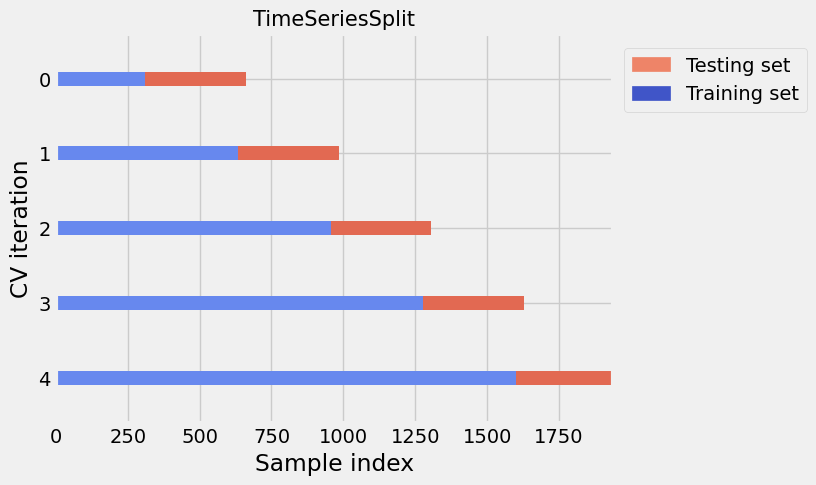

In [ ]:
# 1. TimeSeriesSplit 기본
n_split = 5

tscv = TimeSeriesSplit(n_splits=n_split)

plot_cv_indices(tscv, x_df12_1, n_splits=n_split)

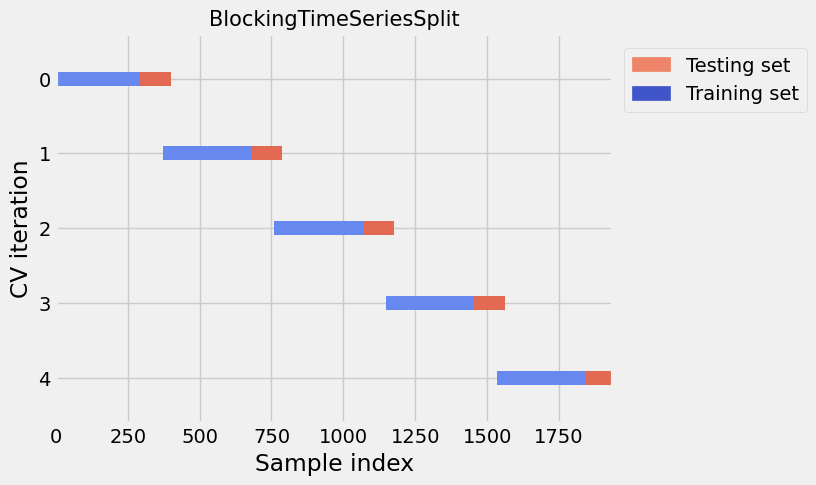

In [ ]:
# 2. Blocked TimeSeriesSplit
btscv = BlockingTimeSeriesSplit(n_splits=n_split)
plot_cv_indices(btscv, x_df2_1, n_splits=n_split)

In [ ]:
# 나중에 쓸꺼같음 일단 두셈
score_df = abs(y_pred-y_test)*100/99
score = 0
for i in score_df:
    if i <=6:
        score += y_test * 4
    elif (i <=8) & (i > 6):
        score += y_test * 3
    else:
        score += 0

In [92]:
## optuna 트리모델 설정

def objective(trial, X, Y):
    params = {
        'n_estimators': trial.suggest_int('n_estimators', 20, 2000),
        'max_depth': trial.suggest_int('max_depth', 3, 20),
        'learning_rate': trial.suggest_float('learning_rate', 0.0001, 0.5),
        'num_leaves': trial.suggest_int('num_leaves', 2, 50),
        'min_child_samples': trial.suggest_int('min_child_samples', 5, 100),
        'reg_alpha': trial.suggest_float('reg_alpha', 1e-8, 1.0),
        'reg_lambda': trial.suggest_float('reg_lambda', 1e-8, 1.0)
    }

    scores = []
    for i, (train_index, test_index) in enumerate(tscv.split(X)):
        x_train, y_train=X.iloc[train_index], Y.iloc[train_index]
        x_test, y_test=X.iloc[test_index], Y.iloc[test_index]

        lgbm_model=LGBMRegressor(**params, boost_from_average=False,
                                  random_state=42)
        lgbm_model.fit(x_train, y_train)

        y_pred=lgbm_model.predict(x_test)
        score = mean_squared_error(y_test,y_pred)


    return score

In [96]:
study = optuna.create_study()
study.optimize(lambda trial: objective(trial, x_df12_3, y_df12_3), n_trials=100)

[I 2023-10-29 05:03:49,821] A new study created in memory with name: no-name-514283bf-6e2d-436c-8346-b6e78a060e9e
[I 2023-10-29 05:03:50,344] Trial 0 finished with value: 148.43722035289395 and parameters: {'n_estimators': 507, 'max_depth': 12, 'learning_rate': 0.26460784246774094, 'num_leaves': 4, 'min_child_samples': 51, 'reg_alpha': 0.7194743145630147, 'reg_lambda': 0.1237259911569168}. Best is trial 0 with value: 148.43722035289395.
[I 2023-10-29 05:03:53,375] Trial 1 finished with value: 153.69982329290892 and parameters: {'n_estimators': 814, 'max_depth': 19, 'learning_rate': 0.17544280922235256, 'num_leaves': 24, 'min_child_samples': 21, 'reg_alpha': 0.10426322521806884, 'reg_lambda': 0.22319615011462182}. Best is trial 0 with value: 148.43722035289395.
[I 2023-10-29 05:03:54,417] Trial 2 finished with value: 170.61716050713446 and parameters: {'n_estimators': 564, 'max_depth': 7, 'learning_rate': 0.3624080959248563, 'num_leaves': 28, 'min_child_samples': 68, 'reg_alpha': 0.6817

In [133]:
study = optuna.create_study()
study.optimize(lambda trial: objective(trial, x_df12_1, y_df12_1), n_trials=100)
# 모델 학습 후 저장 !!! 필 히  이름 바 꿀 것!!!!!!11
model=LGBMRegressor(**study.best_params,random_state=42)
model.fit(x_df12_1,y_df12_1)
joblib.dump(model,"../model/MLP2LGBM_V2/round1/mlp2lgbm_r1_T1.pkl")



study = optuna.create_study()
study.optimize(lambda trial: objective(trial, x_df12_2, y_df12_2), n_trials=100)
# 모델 학습 후 저장 !!! 필 히  이름 바 꿀 것!!!!!!11
model=LGBMRegressor(**study.best_params,random_state=42)
model.fit(x_df12_2,y_df12_2)
joblib.dump(model,"../model/MLP2LGBM_V2/round1/mlp2lgbm_r1_T2.pkl")



study = optuna.create_study()
study.optimize(lambda trial: objective(trial, x_df12_3, y_df12_3), n_trials=100)
# 모델 학습 후 저장 !!! 필 히  이름 바 꿀 것!!!!!!11
model=LGBMRegressor(**study.best_params,random_state=42)
model.fit(x_df12_3,y_df12_3)
joblib.dump(model,"../model/MLP2LGBM_V2/round1/mlp2lgbm_r1_T3.pkl")




study = optuna.create_study()
study.optimize(lambda trial: objective(trial, x_df22_1, y_df22_1), n_trials=100)
# 모델 학습 후 저장 !!! 필 히  이름 바 꿀 것!!!!!!11
model=LGBMRegressor(**study.best_params,random_state=42)
model.fit(x_df22_1,y_df22_1)
joblib.dump(model,"../model/MLP2LGBM_V2/round2/mlp2lgbm_r2_T1.pkl")



study = optuna.create_study()
study.optimize(lambda trial: objective(trial, x_df22_2, y_df22_2), n_trials=100)
# 모델 학습 후 저장 !!! 필 히  이름 바 꿀 것!!!!!!11
model=LGBMRegressor(**study.best_params,random_state=42)
model.fit(x_df22_2,y_df22_2)
joblib.dump(model,"../model/MLP2LGBM_V2/round2/mlp2lgbm_r2_T2.pkl")



study = optuna.create_study()
study.optimize(lambda trial: objective(trial, x_df22_3, y_df22_3), n_trials=100)
# 모델 학습 후 저장 !!! 필 히  이름 바 꿀 것!!!!!!11
model=LGBMRegressor(**study.best_params,random_state=42)
model.fit(x_df22_3,y_df22_3)
joblib.dump(model,"../model/MLP2LGBM_V2/round2/mlp2lgbm_r2_T3.pkl")

[I 2023-10-29 13:36:13,601] A new study created in memory with name: no-name-b1d4f209-b223-4143-86f2-d344e36e1a45
[I 2023-10-29 13:36:15,653] Trial 0 finished with value: 92.83057193501789 and parameters: {'n_estimators': 612, 'max_depth': 14, 'learning_rate': 0.12515245113275905, 'num_leaves': 42, 'min_child_samples': 39, 'reg_alpha': 0.7859672447500442, 'reg_lambda': 0.6233576286391087}. Best is trial 0 with value: 92.83057193501789.
[I 2023-10-29 13:36:17,004] Trial 1 finished with value: 100.12959008406303 and parameters: {'n_estimators': 307, 'max_depth': 13, 'learning_rate': 0.08224706272709245, 'num_leaves': 24, 'min_child_samples': 12, 'reg_alpha': 0.53174442336726, 'reg_lambda': 0.9959888013043962}. Best is trial 0 with value: 92.83057193501789.
[I 2023-10-29 13:36:17,449] Trial 2 finished with value: 92.22211724550773 and parameters: {'n_estimators': 207, 'max_depth': 15, 'learning_rate': 0.27197694857496957, 'num_leaves': 30, 'min_child_samples': 62, 'reg_alpha': 0.922032714

['../model/MLP/round2/mlp2lgbm_r2_T3.pkl']

In [94]:
print(study.best_value)
print(study.best_params)

229.26909909077193
{'n_estimators': 41, 'max_depth': 13, 'learning_rate': 0.15729921567662142, 'num_leaves': 9, 'min_child_samples': 24, 'reg_alpha': 0.9124606950026853, 'reg_lambda': 0.05559201100626268}


# 모델 학습 후 저장

In [70]:
import joblib

In [98]:
# 모델 학습 후 저장 !!! 필 히  이름 바 꿀 것!!!!!!11
model=LGBMRegressor(**study.best_params,random_state=42)
model.fit(x_df12_3,y_df12_3)
joblib.dump(model,"../model/MLP2LGBM_V2/round1/mlp2lgbm_r1_T3.pkl")

['../model/MLP/mlp2lgbm_r1_T3.pkl']

# 예측 시작

## 예측하려는 파일을 이제 시간대별 round별로 나눠야함 
## 해당 기능을 수행하는 함수 선언

In [72]:
## test data set 만드는 함수
def make_test_xy(wf,gf):
    gf.columns = ["time","m0","m1","m2","m3","m4"]
    train = pd.merge(gf,wf,on="time")
    train["time"] = pd.to_datetime(train["time"])
    train["month"]=train["time"].dt.month
    train["day"]=train["time"].dt.day
    train["hour"]=train["time"].dt.hour
    
    train_1 = train[(train["hour"]<=10) & (train["hour"]>=7)]
    train_2 = train[(train["hour"]<=14) & (train["hour"]>=11)]
    train_3 = train[(train["hour"]<=19) & (train["hour"]>=15)]
    
    train11 = train_1[["m0","m1","m2","m3","uv_idx","elevation"]]
    train12 = train_2[["m0","m1","m2","m3","uv_idx","elevation"]]
    train13 = train_3[["m0","m1","m2","m3","uv_idx","elevation"]]
    train21 = train_1.drop(["m0","m1","m2","m3","m4","uv_idx","elevation","time","hour"],axis=1)
    train22 = train_2.drop(["m0","m1","m2","m3","m4","uv_idx","elevation","time","hour"],axis=1)
    train23 = train_3.drop(["m0","m1","m2","m3","m4","uv_idx","elevation","time","hour"],axis=1)
    
    return train11,train12,train13,train21,train22,train23

In [74]:
# 예측에 사용할 데이터 셋 불러오기 
x_pred_ori = pd.read_csv("../data/gen_forecasts/gen_fcst_10_2023-10-23.csv")
x_pred_wf = pd.read_csv("../data/weather_forecasts/wf10_2023-10-23.csv")

In [75]:
# 함수에 넣어서 데이터셋 분리
test11,test12,test13,test21,test22,test23 = make_test_xy(x_pred_wf,x_pred_ori)

In [97]:
model11 = MLP_regressor(6)
model12 = MLP_regressor(6)
model13 = MLP_regressor(6)
model11.load_state_dict(torch.load('../model/MLP2LGBM_V2/round1/m1_mlp11.pt', map_location=torch.device('cpu')))
model12.load_state_dict(torch.load('../model/MLP2LGBM_V2/round1/m1_mlp12.pt', map_location=torch.device('cpu')))
model13.load_state_dict(torch.load('../model/MLP2LGBM_V2/round1/m1_mlp13.pt', map_location=torch.device('cpu')))

<All keys matched successfully>

In [99]:
# 예측 진행 (1차 모델링 y_hat)
y_pred11 = mlpPredict(model11, test11)
y_pred12 = mlpPredict(model12, test12)
y_pred13 = mlpPredict(model13, test13)
y_pred11 = mms_Y_111.inverse_transform(y_pred11).reshape(-1,)
y_pred12 = mms_Y_111.inverse_transform(y_pred12).reshape(-1,)
y_pred13 = mms_Y_111.inverse_transform(y_pred13).reshape(-1,)

In [101]:
model21=joblib.load("../model/MLP/round1/mlp2lgbm_r1_T1.pkl")
model22=joblib.load("../model/MLP/round1/mlp2lgbm_r1_T2.pkl")
model23=joblib.load("../model/MLP/round1/mlp2lgbm_r1_T3.pkl")

In [80]:
y_pred21 = model21.predict(test21)

In [102]:
y_pred21 = model21.predict(test21)
y_pred22 = model22.predict(test22)
y_pred23 = model23.predict(test23)

In [103]:
result1 = y_pred11 + y_pred21
result2 = y_pred12 + y_pred22
result3 = y_pred13 + y_pred23

In [104]:
result = np.concatenate((result1,result2,result3))
result

array([ 10.25103003,  20.01773017,  41.59958489,  59.09831726,
        57.08067546,  60.56545104,  64.27020125,  63.16248678,
        57.82880004,  37.16326818,  12.97002658,  -6.04935423,
       -10.26915885])

In [105]:
len(result)

13

In [158]:
y_pred11

# y_pred13

array([16.915545, 16.915545, 16.91554 , 16.91554 ], dtype=float32)